# classifying fashion objects (multi-class classification)

In [1]:
# prompt: mount

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import torch
from torch import nn

#import computer vision libraries
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import ToPILImage

from matplotlib import pyplot as plt

#checking the version of pytorch and torchvision to check their compatibility

print(f'torch version: {torch.__version__}')
print(f'torchvision version: {torchvision.__version__}')

torch version: 2.4.1+cu121
torchvision version: 0.19.1+cu121


# Getting a dataset

In [3]:
# setup training data

train_data=datasets.FashionMNIST(
    root='/content/drive/My Drive/Colab Notebooks/deep learning practice/Fashion MNIST/',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None # you can transform labels as well

)

#setup test data

test_data=datasets.FashionMNIST(
    root='/content/drive/My Drive/Colab Notebooks/deep learning practice/Fashion MNIST/',
    download=True,
    train=False, #get test data
    transform=ToTensor()

)

In [4]:
# See the first sample of  training data
train_img, train_label = train_data[0]
print(f'image shape: {train_img.shape} , label type: {type(train_label)} label: {train_label}')

test_img, test_label =test_data[0]
print(f'image shape: {test_img.shape} , label: {test_label}')

image shape: torch.Size([1, 28, 28]) , label type: <class 'int'> label: 9
image shape: torch.Size([1, 28, 28]) , label: 9


In [ ]:

len(train_data.data) , len(train_data.targets) ,len(test_data.data) , len(test_data.targets)

(60000, 60000, 10000, 10000)

In [5]:
#see classes
class_names=train_data.classes
len(class_names)
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

### visualizing our data

image shape : torch.Size([1, 28, 28]) label = 8


Text(0.5, 1.0, 'Bag')

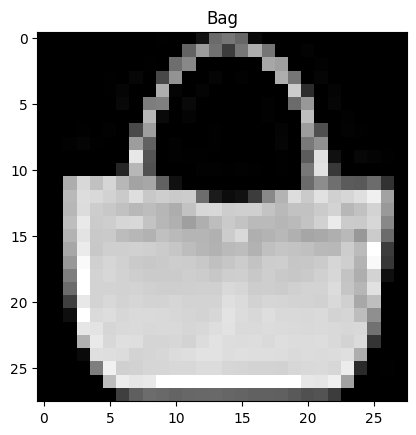

In [ ]:
image, label = train_data[100]
print(f'image shape : {image.shape} label = {label}')
plt.imshow(image.squeeze(),cmap='gray')
plt.title(class_names[label])


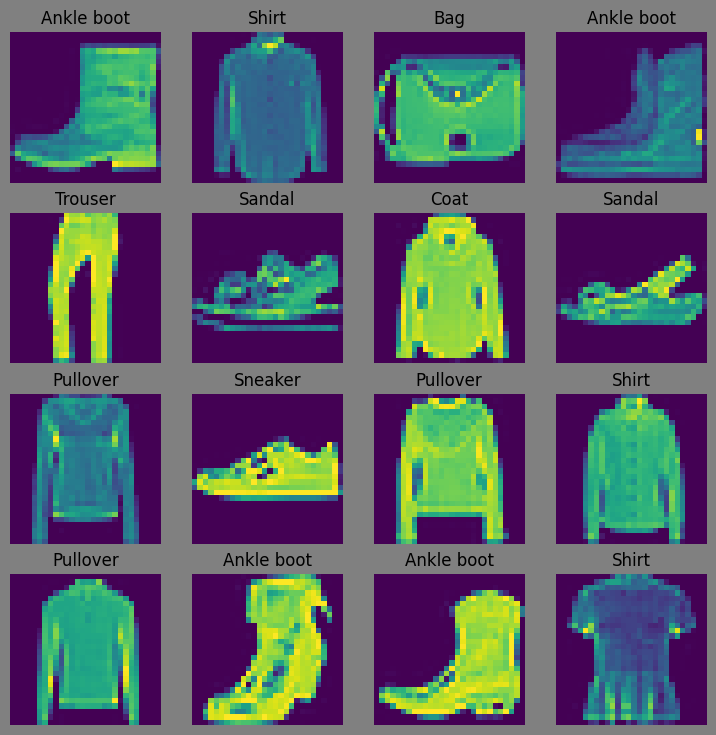

In [ ]:
# plotting more images
torch.manual_seed(42)

fig = plt.figure(figsize=(9,9),facecolor='gray')

rows, cols=4,4

for i in range(1, rows*cols+1):
  rand_idx=torch.randint(0,len(train_data),size=[1]).item()
  img, label= train_data[rand_idx]
  fig.add_subplot(rows,cols,i)
  plt.imshow(img.squeeze())
  plt.title(class_names[label])
  plt.axis(False)


# Prepare DataLoader

In [6]:
from torch.utils.data import DataLoader

#SetUp the batchsize
BATCH_SIZE=32

#turn datasets into iterables(batches)

train_dataloader= DataLoader(train_data,batch_size=BATCH_SIZE,# how many samples per batch?
                             shuffle=True) # shuffle data every epoch?

test_dataloader= DataLoader(test_data,batch_size=BATCH_SIZE,
                            shuffle=False) # don't necessarily have to shuffle the testing data






In [ ]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch= next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape


(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [ ]:
train_dataloader.dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /content/drive/My Drive/Colab Notebooks/deep learning practice/Fashion MNIST/
    Split: Train
    StandardTransform
Transform: ToTensor()

image shape :torch.Size([1, 28, 28])
label: 7 , label shape:torch.Size([])


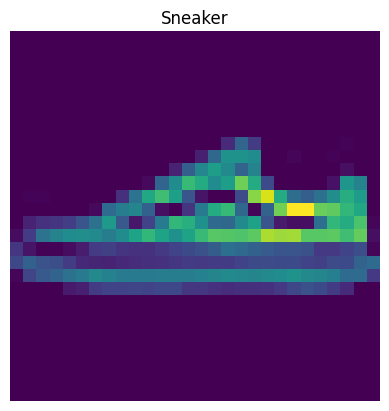

In [ ]:
# Show a sample
torch.manual_seed(42)
rand_idx= torch.randint(0,len(train_features_batch),size=[1]).item()
img, label= train_features_batch[rand_idx], train_labels_batch[rand_idx]
plt.imshow(img.squeeze())
plt.title(class_names[label])
plt.axis(False)

print(f'image shape :{img.shape}')
print(f'label: {label} , label shape:{label.shape}')

# Model 0: Build a baseline model

In [8]:
# building baseline model

class FashionMNISTModelV0(nn.Module):
  def __init__(self,input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()

    self.layer_stack=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,out_features=hidden_units),
        nn.Linear(in_features=hidden_units,out_features=output_shape)

    )


  def forward(self,x):
    return self.layer_stack(x)

In [17]:
# instantiate the model
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)

model_0= FashionMNISTModelV0(input_shape=784,hidden_units=10,output_shape=len(class_names)).to(device)



In [12]:
# Import accuracy metric
import torchmetrics
accuracy_fn= torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

In [18]:
#setUp loss and optimizer

criterion= nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model_0.parameters(),lr=0.1)

In [15]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

### finetuning model_0

In [19]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_device = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = criterion(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)

    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X)

            # 2. Calculate loss (accumulatively)
            test_loss += criterion(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(test_pred.argmax(dim=1),y)

        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time
train_time_end_on_device = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_device,
                                           end=train_time_end_on_device,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.59039 | Test loss: 0.50954, Test acc: 0.82%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47633 | Test loss: 0.47989, Test acc: 0.83%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.45503 | Test loss: 0.47664, Test acc: 0.83%

Train time on cpu: 32.746 seconds


# Model 1 (with non linearity)

In [31]:
# building baseline model

class FashionMNISTModelV1(nn.Module):
  def __init__(self,input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()

    self.layer_stack=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_shape),
        nn.ReLU()

    )


  def forward(self,x):
    return self.layer_stack(x)

In [32]:
#instantiate
torch.manual_seed(42)
model_1=FashionMNISTModelV1(784,10,10).to(device)
next(model_1.parameters()).device

device(type='cpu')

In [33]:
#setUp loss and optimizer

criterion= nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model_1.parameters(),lr=0.1)

In [34]:
# instantiate the model
device = "cuda" if torch.cuda.is_available() else "cpu"

In [37]:
#finetuning model 1
torch.manual_seed(42)
from tqdm.notebook import tqdm # Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs=3

for epoch in tqdm(range(epochs)):
  print(f'epoch: {epoch}\n --------------------')
  train_step(model_1,train_dataloader,criterion,optimizer,accuracy_fn,device)
  test_step(model_1,test_dataloader,criterion,accuracy_fn,device)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)



  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 0
 --------------------
Train loss: 0.64519 | Train accuracy: 0.77%
Test loss: 0.68914 | Test accuracy: 0.75%
epoch: 1
 --------------------
Train loss: 0.62752 | Train accuracy: 0.77%
Test loss: 0.66747 | Test accuracy: 0.76%
epoch: 2
 --------------------
Train loss: 0.61555 | Train accuracy: 0.77%
Test loss: 0.64590 | Test accuracy: 0.76%
Train time on cpu: 38.349 seconds


# Training and Testing Loops

In [35]:
def train_step(model:torch.nn.Module(),
               data_loader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module(),
               optimizer:torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device
                  ):
  model.to(device)
  model.train()
  train_loss,train_acc = 0,0
  for batch, (X,y) in enumerate(data_loader):
    # Send data to GPU
    X, y = X.to(device), y.to(device)

    #1. forward pass
    y_pred=model(X)

    #2. calculate loss,acc
    loss=loss_fn(y_pred,y)
    train_loss+=loss
    train_acc+=accuracy_fn(y_pred.argmax(dim=1),y)

    #3. optimizer zero grad
    optimizer.zero_grad()

    #4.loss backward
    loss.backward()

    #5. optimizer step
    optimizer.step()

  train_loss/=len(data_loader)
  train_acc/=len(data_loader)

  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


def test_step(model:torch.nn.Module(),
               data_loader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module(),
               accuracy_fn,
               device: torch.device = device
                  ):
  model.to(device)
  model.eval()
  test_loss,test_acc = 0,0
  with torch.inference_mode():
    for X,y in data_loader:
        X,y= X.to(device),y.to(device)
        #1. forward pass
        y_pred=model(X)

        #2. calculate loss,acc
        loss=loss_fn(y_pred,y)
        test_loss+=loss
        test_acc+=accuracy_fn(y_pred.argmax(dim=1),y)



    test_loss/=len(data_loader)
    test_acc/=len(data_loader)

  print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")


# Building CNN model

In [39]:
class FashionMNISTModelV2(nn.Module):
  def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
    '''
     Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    '''
    super().__init__()
    self.block1=nn.Sequential(
        nn.Conv2d(in_channels=input_shape,out_channels=hidden_units,
                  kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,
                  kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.block2=nn.Sequential(
        nn.Conv2d(hidden_units,hidden_units,
                  kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,
                  kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden_units*7*7,output_shape)
    )

  def forward(self,x:torch.Tensor):
      x=self.block1(x)
      x=self.block2(x)
      x=self.classifier(x)
      return x

torch.manual_seed(42)

model_2= FashionMNISTModelV2(1,10,len(class_names)).to(device)

model_2

FashionMNISTModelV2(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [40]:
# instantiate loss and optimizer

criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(model_2.parameters(),lr=0.1
                           )

In [41]:
torch.manual_seed(42)

epochs=3
# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

for epoch in tqdm(range(epochs)):
  print(f'epoch : {epoch}/ {epochs}\n -------------------------')
  train_step(model=model_2,
             data_loader=train_dataloader,
             loss_fn=criterion,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device
             )

  test_step(model=model_2,
             data_loader=test_dataloader,
             loss_fn=criterion,
             accuracy_fn=accuracy_fn,
             device=device
             )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 0/ 3
 -------------------------
Train loss: 0.59518 | Train accuracy: 0.78%
Test loss: 0.39500 | Test accuracy: 0.86%
epoch : 1/ 3
 -------------------------
Train loss: 0.36536 | Train accuracy: 0.87%
Test loss: 0.35244 | Test accuracy: 0.87%
epoch : 2/ 3
 -------------------------
Train loss: 0.32588 | Train accuracy: 0.88%
Test loss: 0.32719 | Test accuracy: 0.88%
Train time on cpu: 193.426 seconds


# evaluation

The function will use the model to make predictions on the data in the DataLoader and then we can evaluate those predictions using the loss function and accuracy function.

In [27]:
#model evaluation
# Move values to device
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_pred.argmax(dim=1),y)

        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": f'{acc.item():.2f}'}

In [28]:
# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=criterion, accuracy_fn=accuracy_fn)

model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': '0.83'}

In [38]:
# Calculate model 1 results
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
    loss_fn=criterion, accuracy_fn=accuracy_fn,
    device=device
)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6459039449691772,
 'model_acc': '0.76'}

In [42]:
# Get model_2 results
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=criterion,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32718968391418457,
 'model_acc': '0.88'}

In [ ]:
import pandas as pd

compare_results= pd.DataFrame([model_0_results,model_1_results,model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.511003,81.928914
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.327190,88.069089


In [ ]:
# Add training times to results comparison
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.511003,81.928914,185.244324
1,FashionMNISTModelV1,0.685001,75.019968,45.401795
2,FashionMNISTModelV2,0.327190,88.069089,186.895894


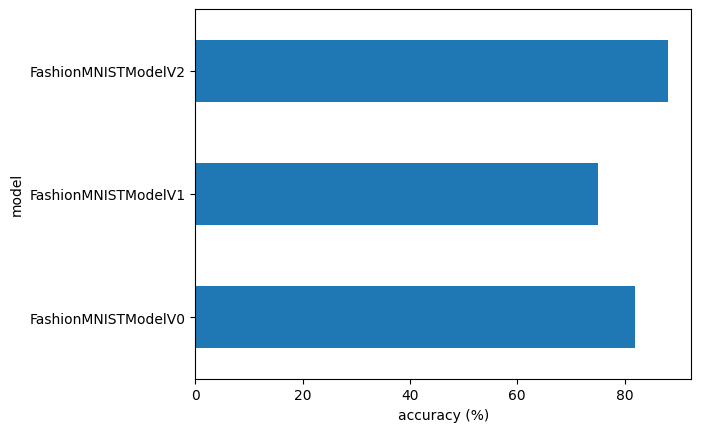

In [ ]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

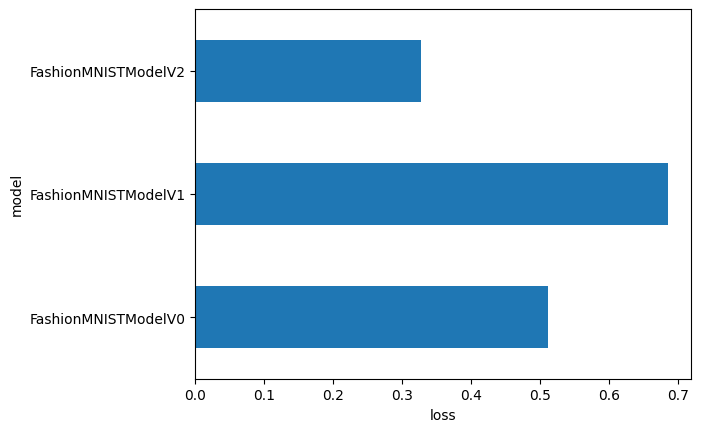

In [ ]:
# Visualize our model results
compare_results.set_index("model_name")["model_loss"].plot(kind="barh")
plt.xlabel("loss")
plt.ylabel("model");

# make prediction

In [ ]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [ ]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [ ]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2,
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[2.5940e-09, 1.3176e-08, 1.8476e-08, 3.9010e-09, 3.1046e-08, 9.9993e-01,
         4.1142e-08, 3.3744e-06, 7.9295e-06, 6.2086e-05],
        [5.4856e-02, 8.3598e-01, 1.5867e-03, 5.8858e-02, 1.5639e-02, 2.1945e-05,
         3.2765e-02, 6.1607e-05, 5.3172e-05, 1.8399e-04]])

In [ ]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [ ]:
test_labels , pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]))

### visualization

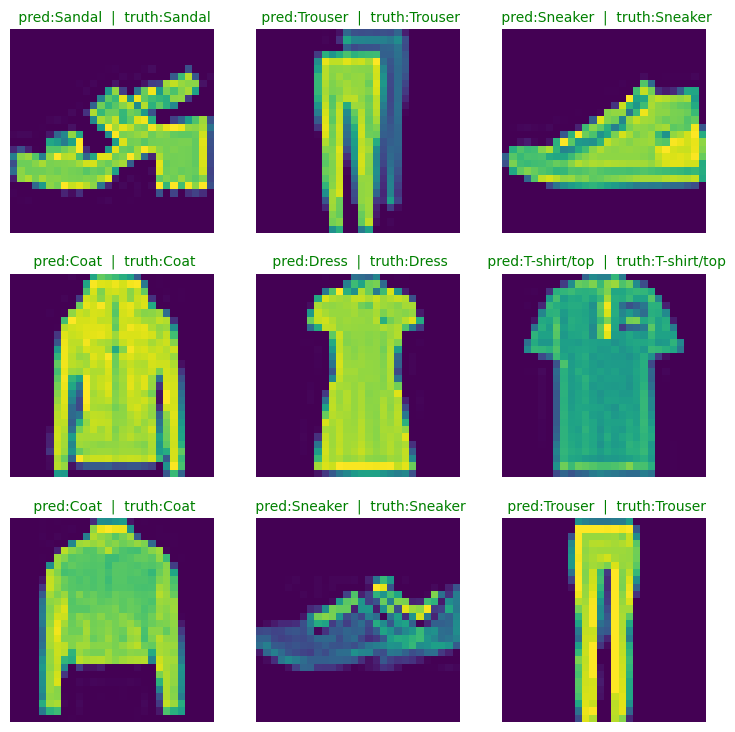

In [ ]:
from operator import truth
plt.figure(figsize=(9,9))

cols=3
rows=3

for i, sample in enumerate(test_samples):
  plt.subplot(rows,cols,i+1)
  plt.imshow(sample.squeeze())

  pred_label=class_names[pred_classes[i]]
  truth_label=class_names[test_labels[i]]

  title_text= f' pred:{pred_label}  |  truth:{truth_label}'

  if pred_label==truth_label:
    plt.title(title_text,fontsize=10,c='g')
  else:
     plt.title(title_text,fontsize=10,c='r')
  plt.axis(False)


### 10. Making a confusion matrix for further prediction evaluation¶

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.1


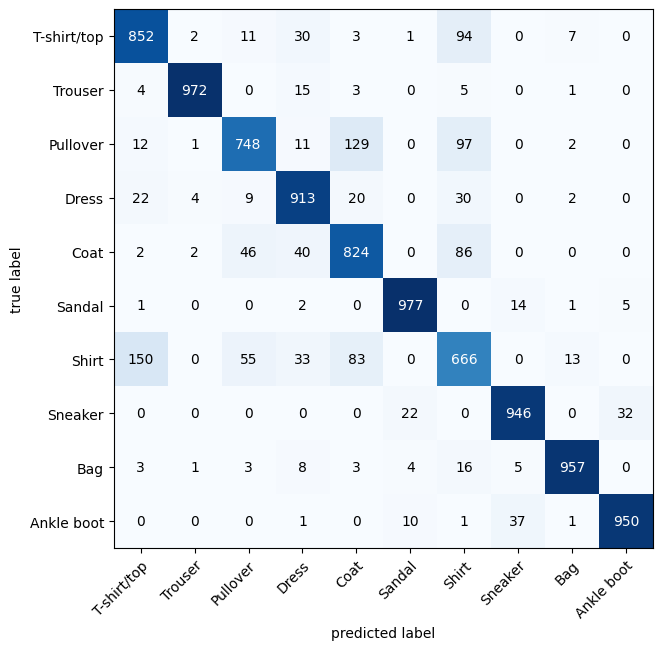

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);


# Save and load best performing model

In [ ]:
from pathlib import Path

from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path('/content/drive/My Drive/Colab Notebooks/deep learning practice/Fashion MNIST/')
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: /content/drive/My Drive/Colab Notebooks/deep learning practice/Fashion MNIST/03_pytorch_computer_vision_model_2.pth


In [ ]:
# Create a new instance of FashionMNISTModelV2 (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                    hidden_units=10, # try changing this to 128 and seeing what happens
                                    output_shape=10)

# Load in the saved state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_2 = loaded_model_2.to(device)

<ipython-input-55-01e1a5266d0e>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


In [ ]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=criterion,
    accuracy_fn=accuracy_fn
)

loaded_model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32718968391418457,
 'model_acc': tensor(0.8807)}

In [ ]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32718968391418457,
 'model_acc': tensor(0.8807)}